In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, os
from sdt_dask.clients.azure.azure_client import AzureClient
from sdt_dask.dataplugs.S3Bucket_plug import S3Bucket
from sdt_dask.dask_tool.runner import Runner

# Import user-defined dataplug

## Pull from S3 database

In [3]:
S3Bucket?

Init signature: S3Bucket(bucket_name)
Docstring:     
Dataplug class for retrieving data from an S3 bucket.
aws configurations for the AWS CLI must be set up in local environment
Init docstring:
Initialize the S3Bucket object with the bucket name.

:param bucket_name: The name of the S3 bucket to pull data from
File:           ~/Desktop/SLAC_clone/solar-data-tools/sdt_dask/dataplugs/S3Bucket_plug.py
Type:           type
Subclasses:     

In [4]:
bucket_name = "pvinsight-dask-baseline"
s3_data_plug = S3Bucket(bucket_name)
KEYS = s3_data_plug._pull_keys()
KEYS = [(key,) for key in KEYS]
s3_data_plug.get_data(KEYS[0])
KEYS = KEYS[:3]
KEYS

s3_data_plug.get_data(KEYS[0])

/Users/liuhaoyang/Desktop/SLAC_clone/solar-data-tools/solardatatools/time_axis_manipulation.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  meas_name = str(df_view[name_key][0])
/Users/liuhaoyang/Desktop/SLAC_clone/solar-data-tools/solardatatools/time_axis_manipulation.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  meas_name = str(df_view[name_key][0])


,ac_power_01
ts,
2017-09-13 06:22:32,0.0
2017-09-13 06:37:32,18.0
2017-09-13 06:52:32,53.0
2017-09-13 07:07:35,70.0
2017-09-13 07:22:34,136.0
...,...
2018-10-12 16:51:04,217.0
2018-10-12 17:06:04,131.0
2018-10-12 17:21:04,54.0


# Initialize the Client

In [5]:
# using the maximum memory limit for Azure VM
client_setup = AzureClient(
    workers=1,
    threads=2,
    memory=15.63,
    resource_group="pvinsight-dask",
    vnet="dask-vnet",
    security_group="pvinsight-dask",
    docker_image="nimishy/p_3.10.11_dask:latest",
    location="westus2",
    vm_size="Standard_D4s_v3",
    public_ingress=True,
    disk_size=30,
    # Environment variables needed to let VM have access to the S3 bucket
    env_vars={ 
        "AWS_ACCESS_KEY_ID": os.environ["AWS_ACCESS_KEY_ID"],
        "AWS_SECRET_ACCESS_KEY": os.environ["AWS_SECRET_ACCESS_KEY"],
        "AWS_REGION": os.environ["AWS_REGION"]
    }
)
# Dask Local Client Initialization
client = client_setup.init_client()

Initializing Azure Cluster with 1 workers, 2 threads and 15.63MiB per worker...
Creating scheduler instance
Assigned public IP
Network interface ready
Creating VM
Created VM dask-357e6e36-scheduler
Waiting for scheduler to run at 20.191.115.75:8786
Scheduler is running


/Users/liuhaoyang/anaconda3/envs/SLAC/lib/python3.10/contextlib.py:142: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources. Hang tight! 
  next(self.gen)


Creating worker instance
Network interface ready
Creating VM
Created VM dask-357e6e36-worker-2c39e63f
Initialized Azure VM Cluster
Initializing Dask Client ...
Dask Dashboard: http://20.191.115.75:8787/status


/Users/liuhaoyang/anaconda3/envs/SLAC/lib/python3.10/site-packages/distributed/client.py:1391: VersionMismatchWarning: Mismatched versions found

+---------+-----------------+-----------------+---------+
| Package | Client          | Scheduler       | Workers |
+---------+-----------------+-----------------+---------+
| python  | 3.10.13.final.0 | 3.10.11.final.0 | None    |
+---------+-----------------+-----------------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


# Use Runner to take in data plug and cluster then run the Dask tasks


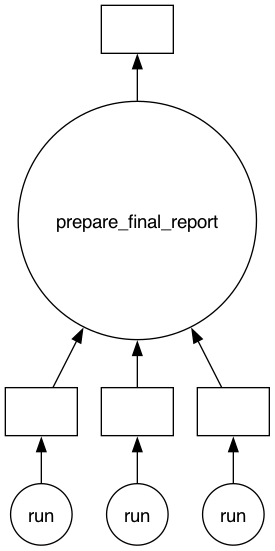

In [6]:
runner = Runner(data_plug=s3_data_plug,
                client=client,
                output_path=f"../result/")

runner.set_up(KEYS, fix_shifts=True, verbose=True)
runner.visualize()

from IPython.display import display, Image
display(Image(filename='sdt_graph.png'))


# Get final result table

In [7]:
runner.get_result()

# The result table and dask report has been saved in the folder you specified in the output_path parameter of the Runner object

Terminated VM dask-357e6e36-worker-2c39e63f
Removed disks for VM dask-357e6e36-worker-2c39e63f
Deleted network interface
Terminated VM dask-357e6e36-scheduler
Removed disks for VM dask-357e6e36-scheduler
Deleted network interface
Unassigned public IP


In [10]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) 
for file in glob.glob("../result/*.csv"):
    df = pd.read_csv(file, index_col=0)
    print(df)

     length  capacity  sampling  quality score  clearness score  inverter clipping  clipped fraction  capacity change  data quality warning  time shift correction  time zone correction  degradation rate [%/yr]  deg rate lower bound [%/yr]  deg rate upper bound [%/yr]  total energy loss [kWh]  degradation energy loss [kWh]  soiling energy loss [kWh]  capacity change energy loss [kWh]  weather energy loss [kWh]  system outage loss [kWh]     runtime get_data_errors run_pipeline_errors run_pipeline_report_errors                           run_loss_analysis_errors     loss_analysis_report_errors       key_field_0
0  1.082192   3.00120        15       0.918987         0.541772              False          0.007595            False                 False                   True                     0                -9.616940                   -12.974504                     -4.88699            -1.845696e+06                 -362716.743819              -95713.813191                         -46.976370